(quickstart)=

# Quickstart 

In [1]:
%config InlineBackend.figure_format = "retina"

## Fundamental parameters estimation with pyABC

This is a simple example of how we can use a package like [pyABC](https://pyabc.readthedocs.io/) to estimate the fundamental parameters for an observed cluster. The user can combine **ASteCA** with any other package of their choosing, here's a list with many Python-based [MCMC and ABC packages](https://gabriel-p.github.io/pythonMCMC/).

We start by instantiating an `isochrones` object with a PARSEC isochrone. This is an example file but you can use whatever isochrone service fits your needs:

In [1]:
import asteca

# Isochrones parameters
isochs = asteca.isochrones(
    isochs_path="../_static/parsec/",
    magnitude={"Gmag": 6390.21},
    color={"G_BPmag": 5182.58, "G_RPmag": 7825.08},
)

Processing PARSEC isochrones for 1 photometric systems, N_met=3, N_age=11...
Isochrone object generated



Next we instantiate a `synthetic` object, passing the `isochs` object we just created (we are using all defaults for the arguments here):

In [3]:
# Synthetic clusters parameters
synthcl = asteca.synthetic(isochs)

Setting random seed to 5967
Sampling selected IMF (chabrier_2014)
Generating binary data
Obtaining extinction coefficients
Synthetic clusters object generated



Now we load our observed cluster as a `pandas.DataFile()` object:

In [4]:
import pandas as pd

# Load the observed cluster with pandas. This is an example cluster used for this notebook,
# containing Gaia DR3 data.
cluster_df = pd.read_csv("../_static/cluster.csv")
cluster_df

,Source,RA_ICRS,DE_ICRS,Plx,e_Plx,pmRA,e_pmRA,pmDE,e_pmDE,RV,e_RV,Gmag,BP-RP,e_Gmag,e_BP-RP
0,5.294007e+18,116.926707,-59.971297,2.444478,0.055783,-3.823004,0.072213,11.327068,0.066137,NaN,NaN,17.220562,2.353176,0.003033,0.020111
1,5.290822e+18,119.845628,-60.539758,2.406173,0.010555,-4.326646,0.014603,11.360535,0.013301,10.732407,3.658482,11.636561,0.674869,0.002759,0.004736
2,5.290718e+18,119.229970,-60.969918,2.482821,0.039980,-4.641178,0.051320,11.626198,0.049038,NaN,NaN,16.534834,2.064721,0.002884,0.008363
3,5.290824e+18,120.039325,-60.559838,2.370707,0.009734,-5.055073,0.013771,11.028563,0.013338,23.445436,2.213122,13.133640,0.938030,0.002774,0.004920
4,5.290718e+18,119.252806,-60.958203,2.452109,0.017472,-4.379975,0.021798,10.819984,0.021279,28.233957,3.800134,14.848411,1.378926,0.002775,0.005270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2754,5.291168e+18,121.597787,-60.307589,1.951287,0.310851,-4.333724,0.380502,12.112275,0.368012,NaN,NaN,18.393740,2.976241,0.005644,0.071329
2755,5.293993e+18,117.705883,-60.078370,1.955193,0.245248,-3.609582,0.269147,11.734518,0.411483,NaN,NaN,18.541553,NaN,0.004193,NaN
2756,5.294558e+18,120.259144,-58.589986,2.154255,0.033122,-4.122722,0.041602,10.115008,0.042414,NaN,NaN,16.089026,1.742559,0.002932,0.008040
2757,5.290987e+18,117.623671,-60.222913,2.374993,0.313164,-3.044262,0.381303,13.019140,0.360147,NaN,NaN,16.817179,1.875015,0.003302,0.009500


and define a ``cluster()`` object using the column names and the DataFrame loaded in the previous step:

In [5]:
my_cluster = asteca.cluster(
    cluster_df=cluster_df,
    magnitude="Gmag",
    e_mag="e_Gmag",
    color="BP-RP",
    e_color='e_BP-RP',
)

Reading and processing cluster data
Cluster object generated



Finally, we need to calibrate our `synthetic` object and instantiate a `likelihood` object. For both operations we need to pass the `my_cluster` object we generated above.

To calibrate the `synthetic` object we also need to pass a dictionary with fixed parameters (optional, we could also not pass anything and fit all the available parameters). We chose `alpha, beta Rv, DR` as fixed parameters: 

In [6]:
# Calibrate the `synthcl` object
fix_params = {"alpha": 0.09, "beta": 0.94, "Rv": 3.1, "DR": 0.}
synthcl.calibrate(my_cluster, fix_params)

then we instantiate a `likelihood` object, which will be used to quantify how similar our observed cluster is to the generated synthetic clusters:

In [7]:
# Instantiate the likelihood
likelihood = asteca.likelihood(my_cluster)

Likelihood object generated



We are now ready to begin the fundamental parameters estimation process with pyABC. pyABC works by minimizing the distance between our data (the observed cluster) and synthetic data (the synthetic clusters). We will need two convenience functions to do this.

The first function required is `model()`. This takes a dictionary with the parameters that are *not* included in `fix_params` when our `synthcl` object was calibrated. This dictionary is used to generate a synthetic cluster via the `generate()` method. The returned variable is a dictionary simply because this is what pyABC expects; this is not a requirement of **ASteCA**.

In [8]:
def model(fit_params):
    """Generate synthetic cluster. pyABC expects a dictionary from this
    function, so we return a dictionary with a single element.
    """
    synth_clust = synthcl.generate(fit_params)
    synth_dict = {"data": synth_clust}
    return synth_dict

Since the `likelihood()` object by default returns a value that *increases* to indicate that the observed data and the synthetic data are more similar, we need to invert this value so that it *decreases* when the synthetic data approaches the observed data (because pyABC wants to *minimize* this value). We thus define a `distance()` function that inverts `lkl` using the `max_lkl` value which is the likelihood of the observed data evaluated on the observed data. I.e.: the largest value that the likelihood can ever return.

Notice that this function receives two arguments from pyABC but we only require one, hence the second argument is dismissed. The function makes use of the dictionary generated by the `model()` function, containing the synthetic cluster.

In [9]:
max_lkl = likelihood.max_lkl

def distance(synth_dict, _):
    """The likelihood is maximized for better fitted models but the pyABC
    distance requires minimization. Hence we normalize and invert.
    """
    lkl = likelihood.get(synth_dict["data"])
    return 1 - lkl / max_lkl


Now we are ready to import pyABC and define the priors for the parameters that are being estimated (i.e: those that were not fixed).

First we use the `min_max()` method of the `synthcl` object to return the minimum and maximum values of the metallicity and the age of the isochrones we loaded initially (if you know these values or want to use a different range, this step can be skipped).

Notice that the priors defined this way for pyABC require using the minimum value and the desired *range*, not the maximum value.

In [10]:
import pyabc
import numpy as np

met_min, met_max, loga_min, loga_max = synthcl.min_max()

# Define a pyABC Distribution(). Uniform distributions are employed for all the parameters
# here but the user can of course change this as desired. See the pyABC docs for more
# information.
priors = pyabc.Distribution(
    {
        "met": pyabc.RV("uniform", met_min, met_max - met_min),
        "loga": pyabc.RV("uniform", loga_min, loga_max - loga_min),
        "dm": pyabc.RV("uniform", 7, 10 - 7),
        "Av": pyabc.RV("uniform", 0, 2 - 0)
    }
)

We create an [ABCSMC](https://pyabc.readthedocs.io/en/latest/api/pyabc.inference.html#pyabc.inference.ABCSMC) object with the `model` and `distance` functions, as well as the priors defined earlier. A population of 100 is usually enough. The tempfile defined below is required by pyABC.

In [11]:
# Define pyABC parameters
pop_size = 100
abc = pyabc.ABCSMC(
    model,
    priors,
    distance,
    population_size=pop_size
)

# This is a temporary file required by pyABC
import os
import tempfile
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "pyABC.db")
abc.new(db_path)

ABC.Sampler INFO: Parallelize sampling on 8 processes.
ABC.History INFO: Start <ABCSMC id=19, start_time=2024-04-17 12:17:54>


Finally, we can run pyABC to perform Approximate Bayesian Inference on our parameters. We set a small number of populations here as an example. Running for ~5 minutes is usually enough (see pyABC's documentation on how to set up a maximum running time):

In [12]:
history = abc.run(minimum_epsilon=0.01, max_nr_populations=10)

ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 1.77192402e-01.
ABC INFO: Accepted: 100 / 211 = 4.7393e-01, ESS: 1.0000e+02.
ABC INFO: t: 1, eps: 1.27492910e-01.
ABC INFO: Accepted: 100 / 202 = 4.9505e-01, ESS: 5.9175e+01.
ABC INFO: t: 2, eps: 8.84040262e-02.
ABC INFO: Accepted: 100 / 283 = 3.5336e-01, ESS: 8.6136e+01.
ABC INFO: t: 3, eps: 7.12130204e-02.
ABC INFO: Accepted: 100 / 286 = 3.4965e-01, ESS: 8.5843e+01.
ABC INFO: t: 4, eps: 5.86028047e-02.
ABC INFO: Accepted: 100 / 373 = 2.6810e-01, ESS: 6.9961e+01.
ABC INFO: t: 5, eps: 5.16570282e-02.
ABC INFO: Accepted: 100 / 425 = 2.3529e-01, ESS: 8.6747e+01.
ABC INFO: t: 6, eps: 4.57535894e-02.
ABC INFO: Accepted: 100 / 364 = 2.7473e-01, ESS: 7.2535e+01.
ABC INFO: t: 7, eps: 4.06922561e-02.
ABC INFO: Accepted: 100 / 315 = 3.1746e-01, ESS: 6.3599e+01.
ABC INFO: t: 8, eps: 3.74207691e-02.
ABC INFO: Accepted: 100 / 499 = 2.0040e-01, ESS: 7.8705e+01.
ABC INFO: t: 9, eps: 3.47669247e-02.
ABC INFO: Accepted: 100 / 470 = 2.1277e-01, 

We are now ready to extract a few important results, along with our fundamental parameters' estimations.

The first line shows the final minimized distance between our observed cluster and the synthetic clusters that were generated. Usually a value below 10% (<0.1) means that a reasonable enough fit was found. Notice that this is true for an analysis like this one, where pyABC was used.

The following line extracts the DataFrame of the last run, and its associated weights. We use the weights to show the effective sample size. This value depends on the population size used above (`pop_size`) and should be large enough to allow decent mean/median/STDDEV values to be extracted.

Finally, the estimations for each fitted parameter is extracted from the DataFrame using the associated weights (again, this is a [pyABC dependent method](https://pyabc.readthedocs.io/en/latest/api/pyabc.weighted_statistics.html#api-weighted-statistics); other packages will do this differently)

In [13]:
final_dist = pyabc.inference_util.eps_from_hist(history)
print("Final minimized distance: {:.2f} ({:.0f}%)".format(final_dist, 100*final_dist))

# Extract last iteration and weights
df, w = history.get_distribution()

ESS = pyabc.weighted_statistics.effective_sample_size(w)
print("Effective sample size: {:.0f}".format(ESS))

print("\nParameters estimation:")
print("----------------------")
for k in df.keys():
    _median = pyabc.weighted_statistics.weighted_median(df[k].values, w)
    _std = pyabc.weighted_statistics.weighted_std(df[k].values, w)
    print("{:<5}: {:.3f} +/- {:.3f}".format(k, _median, _std))


Final minimized distance: 0.03 (3%)
Effective sample size: 73

Parameters estimation:
----------------------
Av   : 0.526 +/- 0.226
dm   : 8.260 +/- 0.237
loga : 7.968 +/- 0.141
met  : 0.013 +/- 0.002


pyABC has many methods to visualize and analyze the results, see [Visualization and analysis](https://pyabc.readthedocs.io/en/latest/visualization.html#visualization-and-analysis). We show here just a few:

array([[<Axes: ylabel='Av'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='dm'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='loga'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='Av', ylabel='met'>, <Axes: xlabel='dm'>,
        <Axes: xlabel='loga'>, <Axes: xlabel='met'>]], dtype=object)

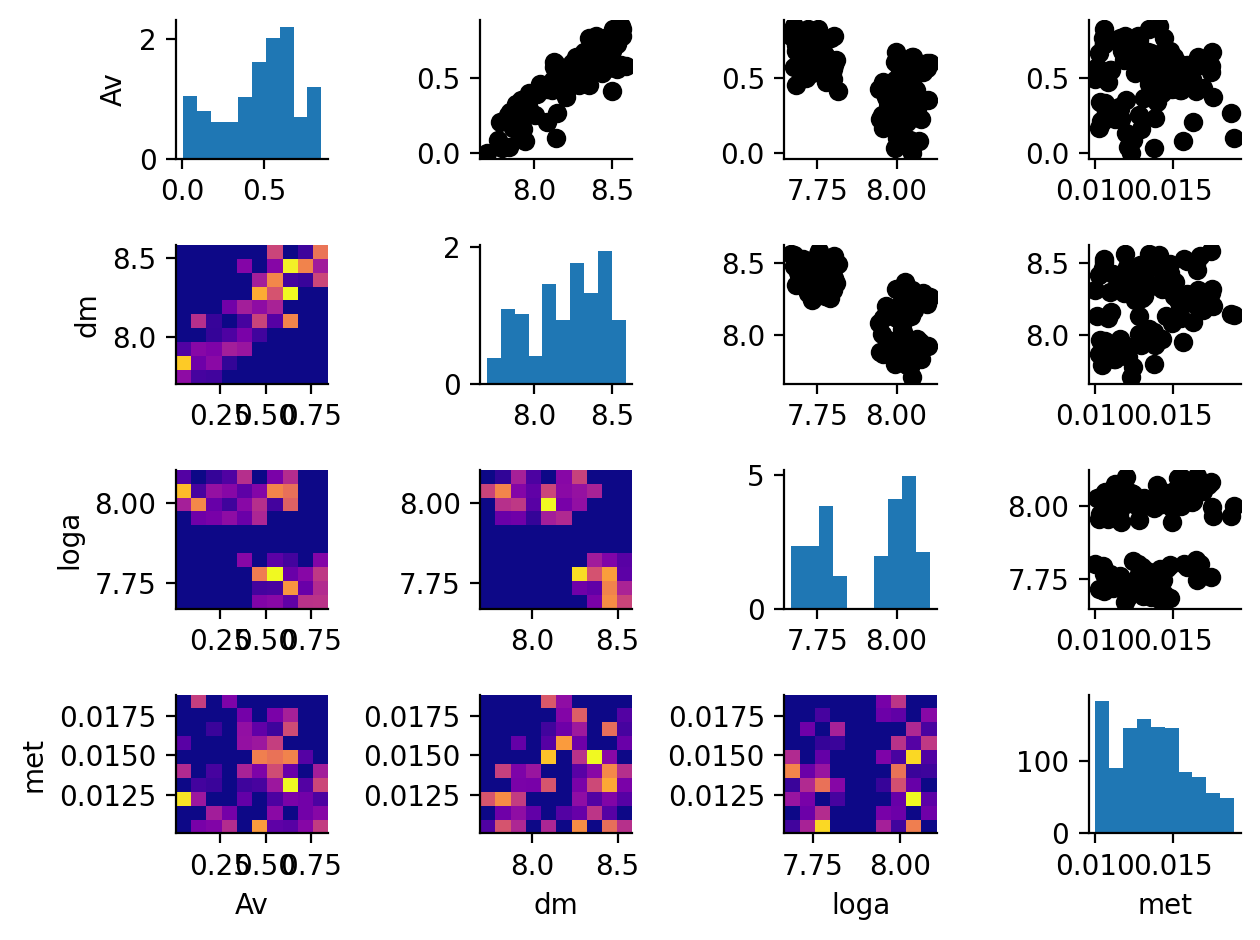

In [14]:
pyabc.settings.set_figure_params("pyabc")  # for beautified plots

# Matrix of 1d and 2d histograms over all parameters
pyabc.visualization.plot_histogram_matrix(history)

array([<Axes: title={'center': 'Parameter Av'}, ylabel='Av'>,
       <Axes: title={'center': 'Parameter dm'}, ylabel='dm'>,
       <Axes: title={'center': 'Parameter loga'}, ylabel='loga'>,
       <Axes: title={'center': 'Parameter met'}, xlabel='Population t', ylabel='met'>],
      dtype=object)

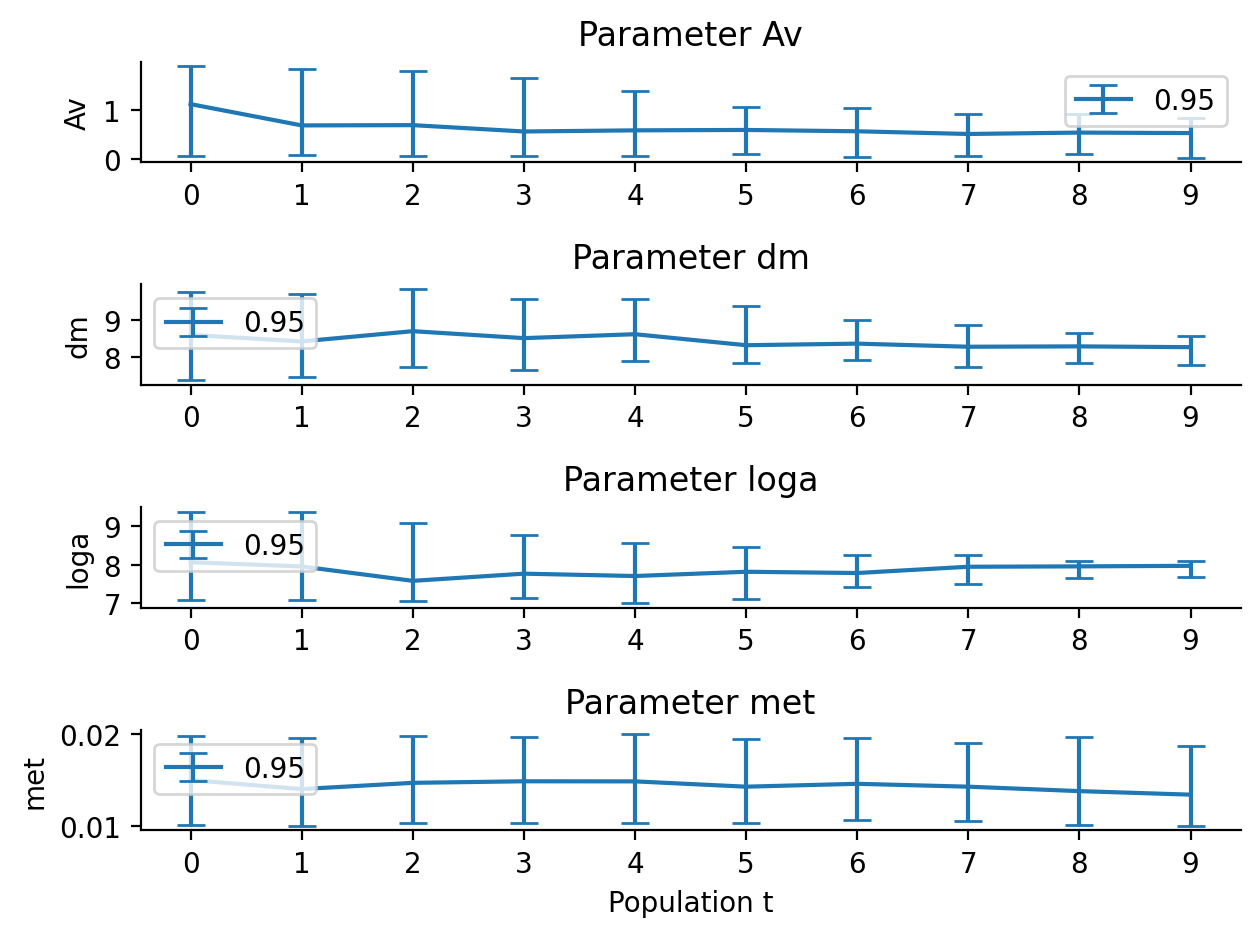

In [15]:
# Credible intervals over time
pyabc.visualization.plot_credible_intervals(history)

We can also use the methods defined in **ASteCA** to plot representations of the "best fit" synthetic clusters, either by themselves or along our observed cluster.

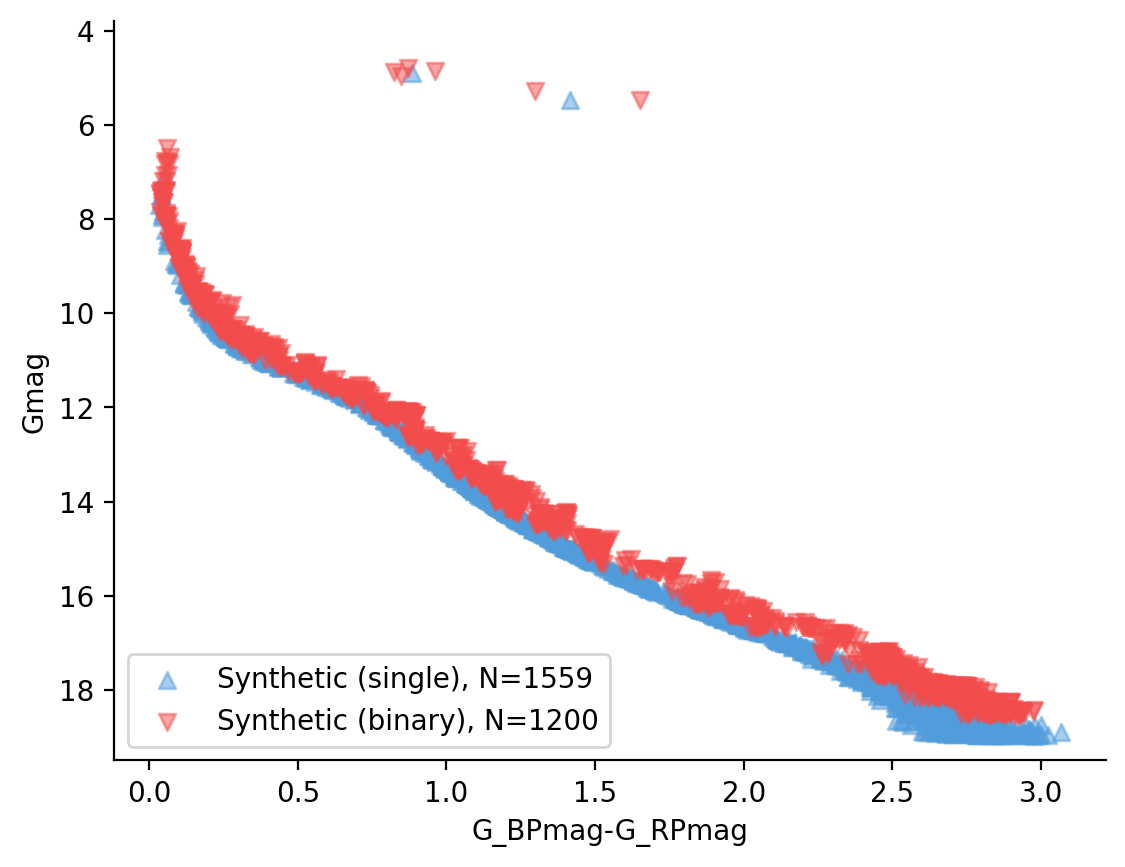

In [16]:
# Extract medians for the fitted parameters
fit_params = {
    k: pyabc.weighted_statistics.weighted_median(df[k].values, w) for k in df.keys()
}

import matplotlib.pyplot as plt
synthcl.synthplot(fit_params)
plt.show()

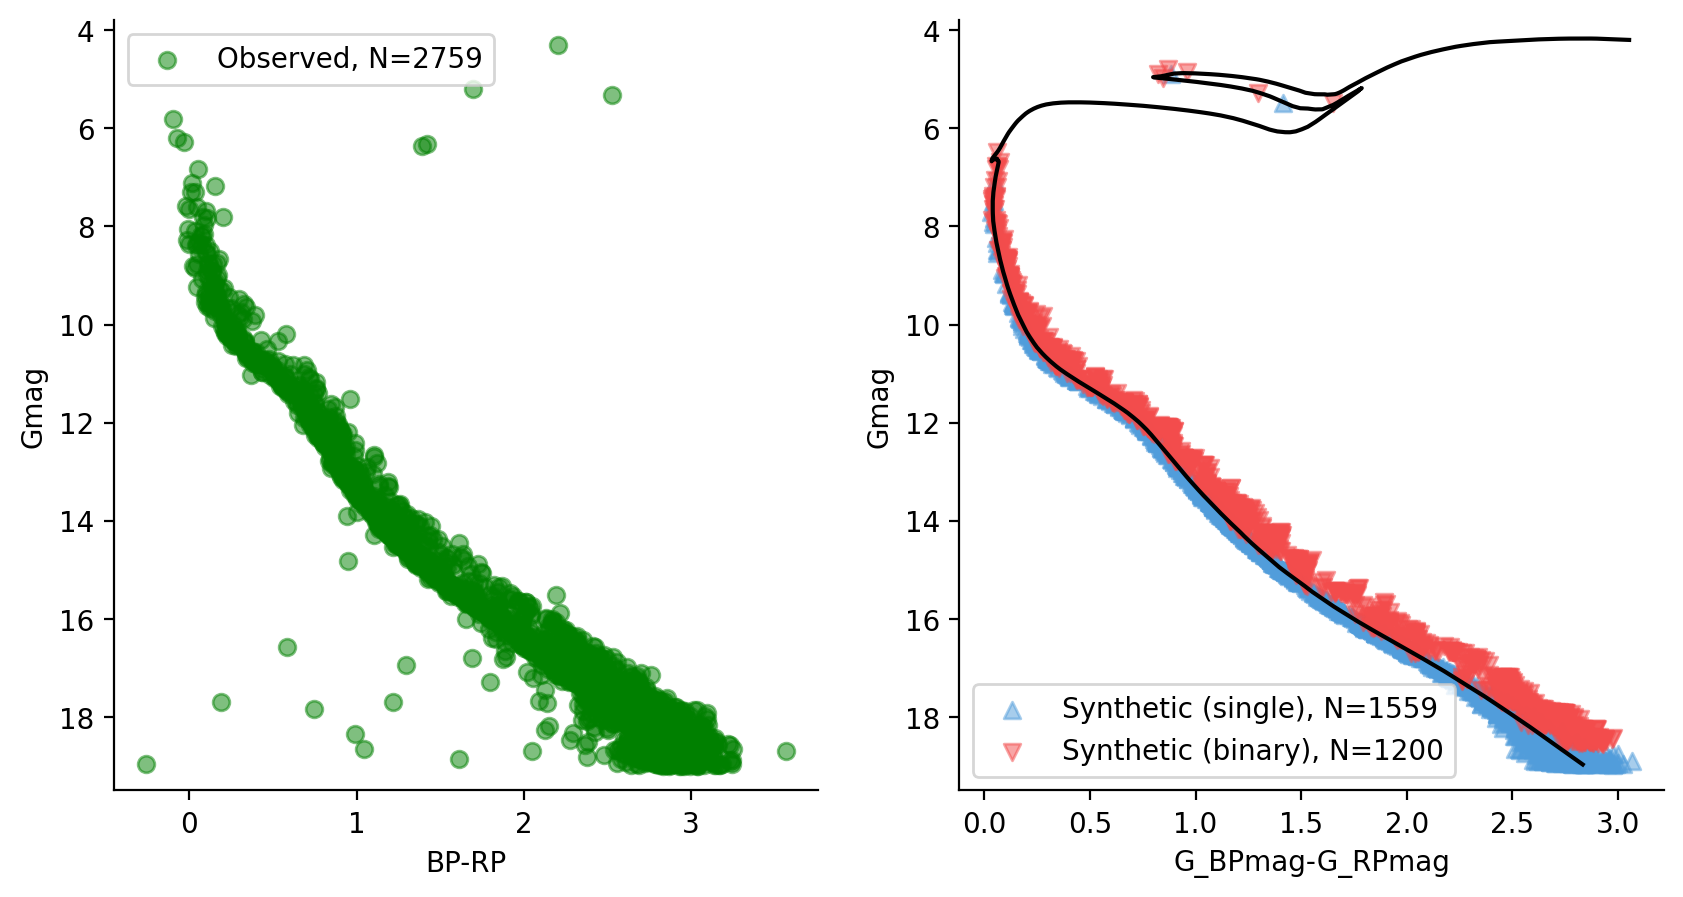

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
my_cluster.clustplot(ax1)
synthcl.synthplot(fit_params, ax2, isochplot=True)
plt.show()